In [30]:
### import statements 
import json
import obonet
from itertools import combinations 
from Bio import Medline
import networkx as nx
import string
from textblob import TextBlob  


import nltk
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import tree

import math

In [31]:
# experiment configurations
MAX_NUMBER_ARTICLE = 1200

In [32]:
# parsing a medline file 
def parse_medline_rmap(medline_file):    
    map_abstracts = {}    
    pmid = ''
    abstract = ''  
    with open(medline_file) as medline_handle:
        records = Medline.parse(medline_handle)
        for record in records:         
            keys = record.keys()            
            if 'PMID' in keys and 'AB' in keys: 

                pmid = record['PMID']
                abstract = record['AB']
                
                map_abstracts[pmid] = abstract.lower()
    return map_abstracts  

In [33]:
def parse_json_gpt_api_data(json_file):

    json_records_map = {}
    # Open and read the JSON file
    with open(json_file, 'r') as json_file:
        json_data = json.load(json_file)

    # Now json_data is a list of dictionaries, each representing an item in the array
    for item in json_data:
        gpt_id = item['GPT-ID']
        title = item['Title']
        abstract = item['Abstract']
        # json_records_map[gpt_id]=(title + " " + abstract)
        json_records_map[gpt_id]=(title + " " + abstract)        
    return json_records_map

In [34]:
def remove_string_special_characters(s):
      
    # removes special characters with ' '
    stripped = re.sub('[^a-zA-z\s]', '', s)
    stripped = re.sub('_', '', stripped)
      
    # Change any white space to one space
    stripped = re.sub('\s+', ' ', stripped)
      
    # Remove start and end white spaces
    stripped = stripped.strip()
    if stripped != '':
            return stripped.lower()

In [35]:
pubmed_abstracts = parse_medline_rmap('../dataset/pubmed-cancerandc-set-2010-2014.txt')
cgpt_abstracts = parse_json_gpt_api_data('../dataset/cancer-gpt-apis.txt')

# cleaning PubMed articles from special characters
clean_pubmed_articles = []
for abst in list(pubmed_abstracts.values())[0:]:
    cleaned = remove_string_special_characters(abst)    
    clean_pubmed_articles.append(cleaned)
    
# cleaning chatGPT articles from special characters
clean_chatGPT_articles = []
for abst in list(cgpt_abstracts.values())[0:]:
    cleaned = remove_string_special_characters(abst)    
    clean_chatGPT_articles.append(cleaned)    
    

In [36]:
print(clean_pubmed_articles[0])

a patient between and years of age died following a polypectomy as part of a colonoscopy surveillance programme for previous polyps as a consequence of this adverse event we have amended our local guidelines while perforation is a recognised complication of polypectomy it was felt that the decision taken to remove the polyp was incorrect the decision to remove a polyp should be at the endoscopists clinical discretion and should depend on polyp size the patients age and comorbidities and their performance status we recommend that polyps mm in size should be regarded as lowrisk polyps and that polypectomy of lowrisk polyps are not essential in patients aged years and older polypectomy of highrisk polyps in patients aged years and older should only be undertaken by experienced endoscopists and with appropriate discussion with the patient prior to the procedure patients aged years should be dissuaded from having further colonoscopic surveillance and should not be included in polyp detectio

In [37]:
stop_words = set(stopwords.words('english'))
special_list = ['abstract']

def stopwords_rem_pubmed(clean_pubmed_training):
    stopped_pubmed_training = []
    for abst in clean_pubmed_training[:MAX_NUMBER_ARTICLE]:
        valid_l = []
        valid_rec = []
        blob_object = TextBlob(abst)
        list_tokens = blob_object.words

        for token in list_tokens:        
            if token not in stop_words:
                valid_l.append(token)            
        valid_rec = ' '.join(valid_l)
        stopped_pubmed_training.append(valid_rec)
    return stopped_pubmed_training
    
    
def stopwords_rem_chatGPT_dataset(clean_chatGPT):    
    stopped_chatGPT_training = []
    for abst in clean_chatGPT_training[:MAX_NUMBER_ARTICLE]:
        valid_l = []
        valid_rec = []
        blob_object = TextBlob(abst)
        list_tokens = blob_object.words

        for token in list_tokens:        
            if (token not in stop_words) and (token not in special_list):
                valid_l.append(token)            
        valid_rec = ' '.join(valid_l)
        stopped_chatGPT_training.append(valid_rec)   
    return stopped_chatGPT_training


def stopwords_rem_chatGPT_article(clean_chatGPT_article):    
    stopped_chatGPT_training = []
    valid_l = []
    valid_rec = []
    blob_object = TextBlob(clean_chatGPT_article)
    list_tokens = blob_object.words

    for token in list_tokens:        
        if (token not in stop_words) and (token not in special_list):
            valid_l.append(token)            
    valid_rec = ' '.join(valid_l)
    # stopped_chatGPT_training.append(valid_rec)   
    return str(valid_rec)

In [38]:
pubmed_articles_ready = stopwords_rem_pubmed(clean_pubmed_articles)

# print(len(stopped_pubmed_training))  
gpt_articles_ready = []
for article in clean_chatGPT_articles:
    gpt_articles_ready.append(stopwords_rem_chatGPT_article(article))
print(len(gpt_articles_ready))    

1202


In [39]:
# print(pubmed_articles_ready[0])
# print('-----')
# print(gpt_articles_ready[0])

In [40]:
# Getting PubMed bigrams
def compute_bigrams(training_articles):
    list_bigrams = []

    vectorizer = CountVectorizer(ngram_range =(2, 2))
    X1 = vectorizer.fit_transform(training_articles)
    features = (vectorizer.get_feature_names_out())
    # print("\n\nX1 : \n", X1.toarray())

    # Applying TFIDF
    # You can still get n-grams here
    vectorizer = TfidfVectorizer(ngram_range = (2, 2))
    X2 = vectorizer.fit_transform(training_articles)
    scores = (X2.toarray())
    # print("\n\nScores : \n", scores)

    # Getting top ranking features
    sums = X2.sum(axis = 0)
    data1 = []
    for col, term in enumerate(features):
        data1.append( (term, sums[0, col] ))
    ranking = pd.DataFrame(data1, columns = ['term', 'rank'])
    words = (ranking.sort_values('rank', ascending = False))

    bigram_ranks = {}
    for index, row in words.iterrows():
        # print(row['term'],'\t\t\t',  row['rank'])

        splits = row['term'].split()
        bigram_ranks[row['rank']] = (splits[0], splits[1])

    count = 0    
    for k, v in bigram_ranks.items():
        # if count < MAX_NUMBER_BIGRAMS:
        #     # print(k,'\t',  v)
        #     count += 1
        list_bigrams.append(v)
    return bigram_ranks

In [41]:
def construct_training_model(training_articles):
    bigrams_map_training = compute_bigrams(training_articles)
    gpt_training_bigrams = bigrams_map_training.values()
    
    graph_training_model = nx.Graph()
    graph_training_model.add_edges_from(list(gpt_training_bigrams))
    
    return graph_training_model    

In [42]:
# construct a network training model from both datasets (gpt and pubmed)

gpt_training_model = construct_training_model(gpt_articles_ready[:100])
pubmed_training_model = construct_training_model(pubmed_articles_ready[:100])

# ----------   Verifying GPT Training  Model ----------# 
print(' -------- GPT Training Model --------')
node_count = len(gpt_training_model.nodes())
edge_count = len(gpt_training_model.edges())
print('Original node count: ', node_count)
print('Original edge count: ', edge_count)

# ----------   Verifying PubMed Training  Model ----------# 
print(' -------- PubMed Training Model --------')
node_count = len(pubmed_training_model.nodes())
edge_count = len(pubmed_training_model.edges())
print('Original node count: ', node_count)
print('Original edge count: ', edge_count)

 -------- GPT Training Model --------
Original node count:  559
Original edge count:  1050
 -------- PubMed Training Model --------
Original node count:  755
Original edge count:  803


In [43]:
def get_giant_lcc(graph_training_model):
    gcc = sorted(nx.connected_components(graph_training_model), key=len, reverse=True)
    giant_cc = graph_training_model.subgraph(gcc[0])
    return giant_cc

In [44]:
print(' -------- GPT GIANT LCC Graph --------')
gpt_lcc = get_giant_lcc(gpt_training_model)
print(gpt_lcc)

print(' -------- PUBMED GIANT LCC Graph --------')
pubmed_lcc = get_giant_lcc(pubmed_training_model)
print(pubmed_lcc)


 -------- GPT GIANT LCC Graph --------
Graph with 489 nodes and 1008 edges
 -------- PUBMED GIANT LCC Graph --------
Graph with 504 nodes and 664 edges


In [45]:
 # STEP2: -- compute individual articles bigrams -------
def calibrate_model(ds_label, begin_index, end_index, training_graph, calibrate_set):

    training_graph_copy = training_graph.copy() 

    ratios_added_per_fold = []
    for abst in calibrate_set[begin_index:end_index]:
        
        tokens = nltk.word_tokenize(abst)

        # compute the bigrams
        bigrams = list(nltk.bigrams(tokens))

        # -------  check if the giant has the bigram components, add new edge 
        # -------          otherwise, don't add new edges
        # -------  count how many nodes            
        count = 0
        added_edges = []
        for bigram in bigrams:

            if training_graph_copy.has_node(bigram[0]) and training_graph_copy.has_node(bigram[1]):

                if not training_graph_copy.has_edge(bigram[0], bigram[1]):

                    training_graph_copy.add_edge(bigram[0], bigram[1])
                    count += 1
                    added_edges.append((bigram[0], bigram[1]))
        ratio_ = count / len(tokens)        
        
        ratios_added_per_fold.append(ratio_) 
        
        training_graph_copy.remove_edges_from(added_edges)      
    return ratios_added_per_fold

In [46]:
def calc_mean(tst_set_list):
    average = sum(tst_set_list) / len(tst_set_list)        
    formatted_avg = float("{:.5f}".format(average))        
    return formatted_avg

In [47]:
count = 0

gpt_means = []
for index in range(100,MAX_NUMBER_ARTICLE):
    label_prefix = 'TEST-'
    if index % 100 == 0:
        count += 1
        calb_ratios_list = calibrate_model(label_prefix + str(count), index, index+100, gpt_lcc, gpt_articles_ready)
        # print(calb_ratios_list)
        tst_mean_g = calc_mean(calb_ratios_list) 
        # print("The average of the list is:", tst_mean_g)
        gpt_means.append(tst_mean_g)
        
gpt_min_value = min(gpt_means)
gpt_max_value = max(gpt_means)        
# print(gpt_means)
for ratio in gpt_means:
    print(ratio)                

0.27947
0.29009
0.26738
0.25622
0.25135
0.28374
0.27115
0.26867
0.25155
0.25541
0.24857


In [48]:
count = 0
pubmed_means = []
for index in range(100,MAX_NUMBER_ARTICLE):
    label_prefix = 'TEST-'
    if index % 100 == 0:
        count += 1
        calb_ratios_list = calibrate_model(label_prefix + str(count), index, index+100, pubmed_lcc, pubmed_articles_ready)
        # print(calb_ratios_list)
        tst_mean_p = calc_mean(calb_ratios_list) 
        # print("The average of the list is:", tst_mean_p)
        pubmed_means.append(tst_mean_p)
        
pubmed_min_value = min(pubmed_means)
pubmed_max_value = max(pubmed_means)        
# print(gpt_means)
for ratio in pubmed_means:
    print(ratio)

0.14473
0.14822
0.15012
0.14254
0.13541
0.14044
0.14316
0.1455
0.14774
0.14771
0.13928


In [49]:
def fit_an_article(article_text, training_graph):
    
    training_graph_copy = training_graph.copy()
    
    # chat_no_added_edges = []
    # for abst in stopped_pubmed_training[begin_index:end_index]:

    tokens = nltk.word_tokenize(article_text)

    # compute the bigrams
    bigrams = list(nltk.bigrams(tokens))

    # -------  check if the giant has the bigram components, add new edge 
    # -------          otherwise, don't add new edges
    # -------  count how many nodes    

    count = 0
    added_edges = []
    for bigram in bigrams:

        if training_graph_copy.has_node(bigram[0]) and training_graph_copy.has_node(bigram[1]):

            if not training_graph_copy.has_edge(bigram[0], bigram[1]):

                training_graph_copy.add_edge(bigram[0], bigram[1])
                count += 1
                added_edges.append((bigram[0], bigram[1]))
    ratio_ = count / len(tokens)        
    training_graph_copy.remove_edges_from(added_edges)
        
    return ratio_

In [50]:
# This will detect the misclassification
# The average of the list is: 0.15012
# The average of the list is: 0.14254
# The average of the list is: 0.13541



misclassified = 0
correct_classified = 0
for article in gpt_articles_ready[200:300]:
    # print(type(article))
    ratio_val = fit_an_article(article, gpt_lcc)
    if ratio_val >= pubmed_min_value and ratio_val <= pubmed_max_value :       
        misclassified+=1
        # print('MISCLASSIFIED: Fit ratio for individual articles: ', ratio_val)
    else:
        correct_classified+=1
        # print('CORRECT CLASS: Fit ratio for individual articles: ', ratio_val)
print('-------------------------------------------------')        
print('MISCLASSIFIED: ', misclassified/100)
print('CORRECT CLASSIFIED: ', correct_classified/100)   
print('-------------------------------------------------')        

-------------------------------------------------
MISCLASSIFIED:  0.0
CORRECT CLASSIFIED:  1.0
-------------------------------------------------


In [51]:
# The average of the list is: 0.29009
# The average of the list is: 0.26738
# The average of the list is: 0.25622
# The average of the list is: 0.25135

misclassified = 0
correct_classified = 0
for article in pubmed_articles_ready[200:MAX_NUMBER_ARTICLE]:
    # print(type(article))
    ratio_val = fit_an_article(article, gpt_lcc)
    if ratio_val >= gpt_min_value and ratio_val <= gpt_max_value :       
        misclassified+=1
        # print('MISCLASSIFIED: Fit ratio for individual articles: ', ratio_val)
    else:
        correct_classified+=1
        # print('CORRECT CLASS: Fit ratio for individual articles: ', ratio_val)
print('-------------------------------------------------')        
print('MISCLASSIFIED: ', misclassified/1000)
print('CORRECT CLASSIFIED: ', correct_classified/1000)   
print('-------------------------------------------------')  

-------------------------------------------------
MISCLASSIFIED:  0.006
CORRECT CLASSIFIED:  0.994
-------------------------------------------------


In [52]:
def distance_to_range(point, range_start, range_end):
    # Calculate the distance to the nearest endpoint of the range
    distance = min(abs(point - range_start), abs(point - range_end))
    return distance

In [53]:
def compute_f1_score(tp, tn, fp, fn):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return f1_score

In [54]:
# two classes classification

two_classes_test_set = []

for pubmed_article in pubmed_articles_ready[200:250]:
    two_classes_test_set.append('PUBMED: ' + pubmed_article)

for gpt_article in gpt_articles_ready[200:250]:
    two_classes_test_set.append('GPT: ' + gpt_article)
    

count = 0
chatgpt_class = 0
pubmed_class = 0

failed_to_classify = 0
misclassified_as_gpt = 0
misclassified_as_pubmed = 0


# RANGE 1: PUBMED
range1_start = pubmed_min_value
range1_end = pubmed_max_value

# RANGE 2: GPT
range2_start = gpt_min_value
range2_end = gpt_max_value

# The articles are labeled with evidence ["PUBMED" or "GPT"]
# getting the first 20 characters is nothing by to show the actual label 
# and be sure that you have identified the correct label

for article in two_classes_test_set:
    
    gpt_ratio_val    = fit_an_article(article, gpt_lcc)
    pubmed_ratio_val = fit_an_article(article, pubmed_lcc)
    
    # Classifying GPT
    if gpt_ratio_val >= range2_start and ratio_val <= range2_end :       
        if article[:20].startswith('GPT'):
            chatgpt_class+=1
            # print('ChatGPT : Fit ratio for individual articles: ', gpt_ratio_val, 'evidence', article[:20])
        else:
            misclassified_as_pubmed+=1
            
    # Classifying PUBMED
    elif pubmed_ratio_val >= range1_start and ratio_val <= range1_end:
        if article[:20].startswith('PUBMED'):
            pubmed_class += 1
            # print('PUBMED : Fit ratio for individual articles: ', pubmed_ratio_val, 'evidence', article[:20])
        else: 
            misclassified_as_gpt+=1
        
    else:
        # Calculate distances
        distance_to_range1 = distance_to_range(pubmed_ratio_val, range1_start, range1_end)
        distance_to_range2 = distance_to_range(gpt_ratio_val, range2_start, range2_end) 
        
        # print('distance to range 1: ', distance_to_range1)
        # print('distance to range 2: ', distance_to_range2)        
        
        # RANGE 1: PUBMED ARTICLES SHOULD SLIDE IN HERE
        # If ChatGPT slide in it is FLASE POSITIVE
        if distance_to_range1 < distance_to_range2:
            if article[:20].startswith('GPT'):
                misclassified_as_pubmed+=1
                # print('PUBMED PREDICTED INCORRECTLY => ', 'ratio:', pubmed_ratio_val ,', evidence:', article[:20])                
            else:   
                # count+=1
                pubmed_class += 1
                # print('PUBMED CLASS PREDICTED => ', 'ratio:', pubmed_ratio_val , ', evidence:', article[:20])

        # RANGE 2: GPT SHOULD ARTICLES SHOULD SLIDE IN HERE
        elif distance_to_range2 < distance_to_range1:
            if article[:20].startswith('PUBMED'):                
                misclassified_as_gpt+=1
                # print('GPT PREDICTED INCORRECTLY => ', 'ratio:', gpt_ratio_val , ', evidence:', article[:20])                     
            else:
                chatgpt_class += 1
                # print('GPT CLASS PREDICTED => ', 'ratio:', gpt_ratio_val , ', evidence:', article[:20])

    # print(' -------------------------------- ')
    
    
print('---------------COUNTS---------------------------')    
# print('Number of publications analyzed: ', count)
print('PUBMED CLASSIFIED (TP): ', pubmed_class)   
print('CHATGPT CLASSIFIED (TN): ', chatgpt_class)   
print('FAILED_TO_CLASSIFY: ', failed_to_classify)
print('PUBMED MISCLASSIFIED AS GPT: (FN)', misclassified_as_gpt) 
print('GPT MISCLASSIFIED AS PUBMED: (FP)', misclassified_as_pubmed)   
print('-------------------------------------------------') 
    

tp = pubmed_class
tn = chatgpt_class
fn = misclassified_as_gpt
fp = misclassified_as_pubmed


# tp, tn, fp, fn
print("F1 Score: ", compute_f1_score(tp, tn, fp, fn))

---------------COUNTS---------------------------
PUBMED CLASSIFIED (TP):  50
CHATGPT CLASSIFIED (TN):  44
FAILED_TO_CLASSIFY:  0
PUBMED MISCLASSIFIED AS GPT: (FN) 2
GPT MISCLASSIFIED AS PUBMED: (FP) 4
-------------------------------------------------
F1 Score:  0.9433962264150944


In [55]:
pubmed_training = pubmed_articles_ready[:100]
gpt_training = gpt_articles_ready[:100]

pubmed_training.extend(gpt_training)
two_classes_training_set = gpt_training

In [56]:
import algo_evals as ae

In [57]:
# classification performance of Two Classes Articles
ae.classify(two_classes_training_set, two_classes_test_set)

Classifier: Multinomial Naive Bayes
TP: 17, FP: 33, FN: 25, TN: 25
F1 Score: 0.46296296296296297

Classifier: Linear SVM
TP: 25, FP: 25, FN: 23, TN: 27
F1 Score: 0.5294117647058824

Classifier: Random Forest
TP: 6, FP: 44, FN: 15, TN: 35
F1 Score: 0.5426356589147288

Classifier: Logistic Regression
TP: 25, FP: 25, FN: 25, TN: 25
F1 Score: 0.5



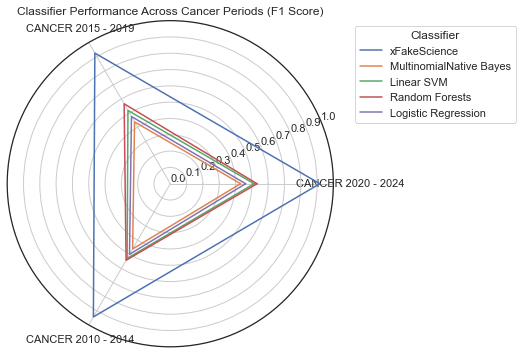

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Define the classifiers and their corresponding F1 scores for each cancer period
classifiers = ['xFakeScience', 'MultinomialNative Bayes', 'Linear SVM', 'Random Forests', 'Logistic Regression']
cancer_periods = ['CANCER 2020 - 2024', 'CANCER 2015 - 2019', 'CANCER 2010 - 2014']
f1_scores = {
    'xFakeScience': [0.917, 0.925, 0.943],
    'MultinomialNative Bayes': [0.431, 0.438, 0.462],
    'Linear SVM': [0.514, 0.519, 0.529],
    'Random Forests': [0.532, 0.566, 0.542],
    'Logistic Regression': [0.462, 0.476, 0.50]
}

# Define the number of metrics (e.g., precision, recall, F1 score)
num_metrics = len(cancer_periods)

# Define the angles for each metric
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()

# Repeat the first angle to close the plot
angles += angles[:1]

# Plot the radial plot
plt.figure(figsize=(10, 6))
for classifier in classifiers:
    f1_scores_classifier = f1_scores[classifier]
    f1_scores_classifier += f1_scores_classifier[:1]
    plt.polar(angles, f1_scores_classifier, label=classifier)

plt.title('Classifier Performance Across Cancer Periods (F1 Score)')
plt.legend(title='Classifier', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(angles[:-1], cancer_periods)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.grid(True)
plt.show()


<Figure size 720x432 with 0 Axes>

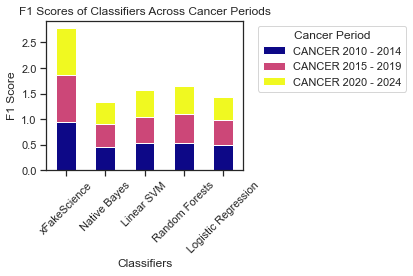

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the dictionary containing the data
data = {
    'Classifier': ['xFakeScience', 'Native Bayes', 'Linear SVM', 'Random Forests', 'Logistic Regression'],
    'CANCER 2010 - 2014': [0.943, 0.462, 0.529, 0.542, 0.50],
    'CANCER 2015 - 2019': [0.925, 0.438, 0.519, 0.566, 0.476],
    'CANCER 2020 - 2024': [0.917, 0.431, 0.514, 0.532, 0.462]


}

# Create the DataFrame
df = pd.DataFrame(data)

# Set the index to 'Classifier'
df.set_index('Classifier', inplace=True)

# Plot the stacked bar plot
plt.figure(figsize=(10, 6))
df.plot(kind='bar', stacked=True, cmap='plasma')
plt.title('F1 Scores of Classifiers Across Cancer Periods')
plt.xlabel('Classifiers')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.legend(title='Cancer Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 720x720 with 0 Axes>

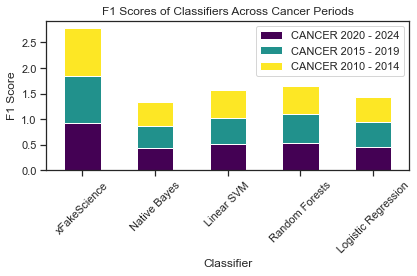

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the dictionary containing the data
data = {
    'Classifier': ['xFakeScience', 'Native Bayes', 'Linear SVM', 'Random Forests', 'Logistic Regression'],
    'CANCER 2020 - 2024': [0.917, 0.431, 0.514, 0.532, 0.462],
    'CANCER 2015 - 2019': [0.925, 0.438, 0.519, 0.566, 0.476],
    'CANCER 2010 - 2014': [0.943, 0.462, 0.529, 0.542, 0.50]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Set the index to 'Classifier'
df.set_index('Classifier', inplace=True)

# Plot the stacked bar plot
plt.figure(figsize=(10, 10))
ax = df.plot(kind='bar', stacked=True, cmap='viridis')
plt.title('F1 Scores of Classifiers Across Cancer Periods')
plt.xlabel('Classifier')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
# plt.legend(title='Cancer Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Adjust x-labels position
plt.subplots_adjust()

plt.show()



<Figure size 720x432 with 0 Axes>

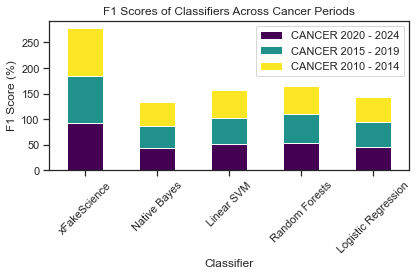

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the dictionary containing the data
data = {
    'Classifier': ['xFakeScience', 'Native Bayes', 'Linear SVM', 'Random Forests', 'Logistic Regression'],
    'CANCER 2020 - 2024': [0.917, 0.431, 0.514, 0.532, 0.462],
    'CANCER 2015 - 2019': [0.925, 0.438, 0.519, 0.566, 0.476],
    'CANCER 2010 - 2014': [0.943, 0.462, 0.529, 0.542, 0.50]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Set the index to 'Classifier'
df.set_index('Classifier', inplace=True)

# Convert the data to percentages
df *= 100

# Plot the stacked bar plot
plt.figure(figsize=(10, 6))
ax = df.plot(kind='bar', stacked=True, cmap='viridis')
plt.title('F1 Scores of Classifiers Across Cancer Periods')
plt.ylabel('F1 Score (%)')
plt.xticks(rotation=45)
# plt.legend(title='Cancer Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Adjust x-labels position
ax.set_xticks(range(len(df.index)))
ax.set_xticklabels(df.index, ha='center')

# Save the figure to a file
plt.savefig('../figures/can_comp_f1_scores.png', dpi=300)

plt.show()
